In [23]:
import constants
constants.GRAVITATIONAL_ACCELERATION=0.0
from ParticleClass import Swarm
from collectorSimulationHelperFunctions import build_collector_lattice,CollectorSwarmAnalyzer
from phaseSpaceAnalysis_Functions import transfer_particles_to_new_swarm
from SwarmTracerClass import SwarmTracer
import numpy as np
import matplotlib.pyplot as plt
import time
ap=None
lattice=build_collector_lattice(interp_density_mult=4,ap=ap)
st=SwarmTracer(lattice)
%matplotlib inline
# lattice.show_lattice()

In [24]:
ap=lattice.el_list[1].ap
pr_max=lattice.speed_nominal*(1e2*ap/72)
print(ap)

0.0485856406802676


In [73]:
x_lens_input=.72
rp=.05
def is_Particle_Valid_geom(qi,pi):
    """Does a particle even survive the lens geometry"""
    dt=(x_lens_input-qi[0])/pi[0]
    q_lens=qi+pi*dt
    r=np.sqrt(q_lens[1]**2+q_lens[2]**2) #get radius using y and z
    if r<=rp:
        return True
    else:
        return False

In [139]:
def rotate_swarm(swarm):
    for particle in swarm:
        particle.pi[0]*=-1
        particle.qi[0]+=5e-10
def make_point_source_swarm(num_particles):
    swarm=st.initalize_pseudorandom_swarm_in_phase_space(1e-9,pr_max,1e-9,num_particles,same_seed=True)
    rotate_swarm(swarm)
    return swarm
def make_simulated_swarm(num_particles):
    file='/Users/williamdebenham/Desktop/storageRing/storageRing/storageRingModel/massiveSwarms/100millionParticles_3mk.txt'
    particle_data=np.loadtxt(file)
    np.random.shuffle(particle_data)
    swarm_initial=Swarm()
    delta_vx=-3.0
    i=0
    for data in particle_data:
        i+=1
        x,y,z,px,py,pz=data
        px+=delta_vx
        qi,pi=np.array([x,y,z]),np.array([px,py,pz])
        if is_Particle_Valid_geom(qi,pi):
            swarm_initial.add_new_particle(qi=qi,pi=pi)
            if len(swarm_initial)==num_particles:
                break
    return swarm_initial

def make_small_source_swarm(num_particles):
    swarm=st.initalize_pseudorandom_swarm_in_phase_space(1e-3,pr_max,1e-9,num_particles,same_seed=True)
    rotate_swarm(swarm)
    return swarm

def make_square_source_swarm(num_particles):
    circle_factor=4/np.pi
    swarm_square=st.initalize_pseudorandom_swarm_in_phase_space(2e-3,pr_max,1e-9,num_particles*circle_factor,same_seed=True,circular=False)
    swarm_valid=Swarm()
    for particle in swarm_square:
        _,py,pz=particle.pi
        if np.sqrt(py**2+pz**2)< pr_max:
            swarm_valid.add(particle)
    rotate_swarm(swarm_valid)
    return swarm_valid
def make_swarm(num_particles_to_trace,source_type):
    if source_type=='point':
        swarm_initial=make_point_source_swarm(num_particles_to_trace)
    elif source_type=='circle':
        swarm_initial=make_small_source_swarm(num_particles_to_trace)
    elif source_type=='simulated':
        swarm_initial=make_simulated_swarm(num_particles_to_trace)
    elif source_type=='square':
        swarm_initial=make_square_source_swarm(num_particles_to_trace)
    else:
        raise NotImplementedError
    return swarm_initial


In [127]:
from ParticleClass import Swarm

def trace_swarm(num_particles_to_trace,source_type='point'):
    swarm_initial=make_swarm(num_particles_to_trace,source_type)
    work_size=500_000
    swarm_traced=st.trace_swarm_through_lattice(swarm_initial,5e-6,1.0,parallel=False,use_fast_mode=True,steps_per_logging=10,accelerated=True)
    return swarm_traced
t=time.time()
num_particles_approx=30_000_000
source_type='simulated'
swarm_traced=trace_swarm(num_particles_approx,source_type=source_type)
num_particles=len(swarm_traced)
analyzer=CollectorSwarmAnalyzer(swarm_traced,lattice)
print(time.time()-t)

1081386
1081386 30000000
82.81422281265259


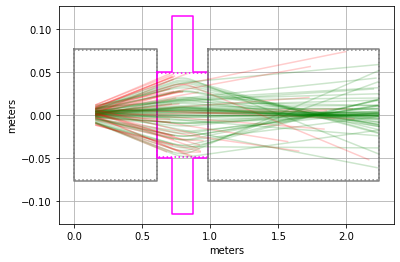

In [72]:
%matplotlib inline
swarm_initial_small=make_swarm(100,source_type='simulated')
swarm_traced_small=st.trace_swarm_through_lattice(swarm_initial_small,1e-5,1.0,parallel=True,use_fast_mode=False,accelerated=True,steps_per_logging=4)
lattice.show_lattice(swarm=swarm_traced_small,trace_line_alpha=.2,true_aspect_ratio=False,plot_outer=True,save_title='trace',dpi=300,show_markers=False)
swarm_initial_small

In [140]:
swarm_initial_small=make_swarm(1000,source_type='simulated')

In [68]:
print(swarm_initial_small.particles[3])

------particle-------
qi: [-1.e-10  0.e+00  0.e+00]
pi: [-210.    0.    0.]
p: None
q: None
current element: None 
 revolution: 0 



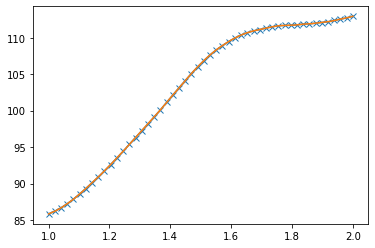

D90 min:  85.83  mm
D90 min location:  100.0  cm


In [76]:
from helperTools import make_dense_curve_1D_RBF
x_min,x_max=analyzer.end_drift_x_min_max()
x_vals=np.linspace(1.0,2.0,50)
d90_vals=[analyzer.D_90(x) for x in x_vals]
plt.plot(x_vals,d90_vals,marker='x')
x,y=make_dense_curve_1D_RBF(x_vals,d90_vals)
plt.plot(x,y)
plt.show()
d90_min=np.nanmin(y)
d90_x_focus=x[np.nanargmin(y)]
print("D90 min: ", round(d90_min,2) , ' mm')
print("D90 min location: ", round(1e2*d90_x_focus,1), ' cm')

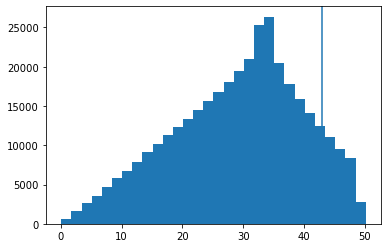

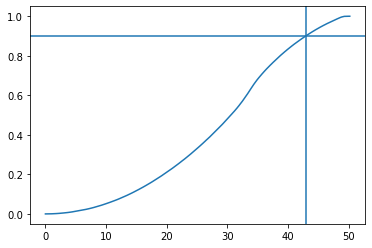

In [36]:
y_arr,z_arr=analyzer.interpolate(d90_x_focus)
r_arr=np.sqrt(y_arr**2+z_arr**2)
R_90=d90_min/2
plt.hist(r_arr,bins=30)
plt.axvline(R_90)
plt.show()
r_arr_sorted=np.sort(r_arr)
counts=np.ones(len(r_arr))
fraction=np.cumsum(counts)/sum(counts)
plt.plot(r_arr_sorted,fraction)
plt.axvline(R_90)
plt.axhline(.9)
plt.show()

In [80]:
r_max_fwhm=5
delta_r=r_max_fwhm/100
num_bins=round(r_max_fwhm/delta_r)
x_range=np.linspace(1.7,1.85,30)

def make_FWHM_profile():
    fwhm_vals=[analyzer.fwhm(x, r_max_fwhm, bins_center_sep_mm=delta_r) for x in x_range]
    # x,y=make_dense_curve_1D_RBF(x_range,fwhm_vals,smoothing=0)
    return x_range,fwhm_vals
def find_fwhm_min_and_location():
    x,y=make_FWHM_profile()
    fwhm_min=np.nanmin(y)
    fwhm_x_focus=x[np.nanargmin(y)]
    return fwhm_min,fwhm_x_focus

In [93]:
def show_and_get_fwhm_results():
    fwhm_min,fwhm_x_focus=find_fwhm_min_and_location()
    x,y=make_FWHM_profile()
    plt.plot(x,y)
    plt.show()
    print("FWHM min: ",round(fwhm_min ,2), ' mm')
    print("FWHM min location: ",round(1e2*fwhm_x_focus,1), ' cm')
    return fwhm_min,fwhm_x_focus
# fwhm_min,fwhm_x_focus=show_and_get_fwhm_results()
fwhm_x_focus=1.76

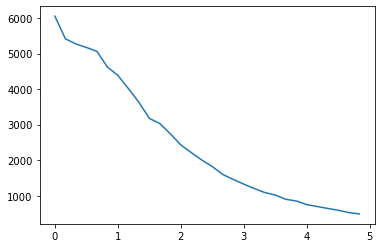

3.3372670600393373

In [94]:
%matplotlib inline
x=1.76
r_cutoff=5
bin_size=r_cutoff/30
r_vals,density=analyzer.transvers_position_density(x,r_cutoff,bin_size)
plt.plot(r_vals,density)
# plt.axhline(density.max()/2)
# plt.axvline(x=hwhm)
plt.show()
analyzer.fwhm(x,r_cutoff,bins_center_sep_mm=bin_size)

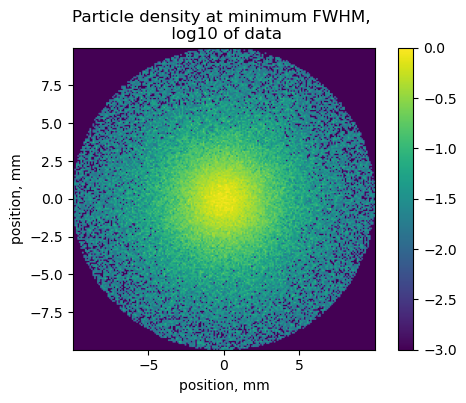

In [95]:
%matplotlib inline
x_interp=fwhm_x_focus
y_vals,z_vals=analyzer.interpolate(x_interp,max_radius_mm=10)
image,binx,biny=np.histogram2d(y_vals,z_vals,bins=200)
image=image/image.max()
image=np.log10(image+1e-3)
plt.figure(dpi=100)
plt.title("Particle density at minimum FWHM, \n log10 of data")
plt.imshow(image,extent=[binx.min(),binx.max(),biny.min(),biny.max()])
plt.xlabel("position, mm")
plt.ylabel("position, mm")
plt.colorbar()
plt.show()
# r_arr=np.sqrt(y_vals**2+z_vals**2)
# plt.hist(r_arr,bins=50)
# plt.show()

112543.0


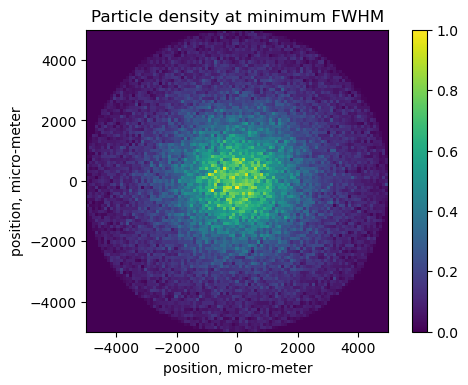

[-4989.09696734254, 4999.607368673366, -4989.09696734254, 4999.607368673366]

In [96]:
%matplotlib inline
x_interp=1.76
r_max_fwhm=5
y_vals,z_vals=analyzer.interpolate(x_interp,max_radius_mm=r_max_fwhm)
num_bins=100
bins=np.linspace(y_vals.min(),y_vals.max(),num_bins)
image,binx,biny=np.histogram2d(y_vals,z_vals,bins=bins)
print(np.sum(image))
binx=binx*1e3
biny=biny*1e3
image=image/image.max()
image=np.rot90(image)
plt.figure(dpi=100)
plt.title("Particle density at minimum FWHM")
plt.imshow(image,extent=[binx.min(),binx.max(),biny.min(),biny.max()])
plt.xlabel("position, micro-meter")
plt.ylabel("position, micro-meter")
plt.colorbar()
plt.show()
# r_arr=np.sqrt(y_vals**2+z_vals**2)
# plt.hist(r_arr,bins=50)
# plt.show()
[binx.min(),binx.max(),biny.min(),biny.max()]

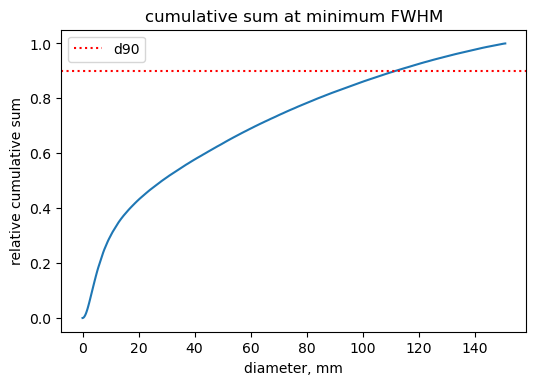

In [97]:
# cumulative particle distribution
%matplotlib inline
y_vals,z_vals=analyzer.interpolate(fwhm_x_focus)
r_vals=np.sort(np.sqrt(y_vals**2+z_vals**2))
diam_vals=2*r_vals
counts=np.ones(len(r_vals))
cum_sum=np.cumsum(counts)
cum_sum=cum_sum/cum_sum.max()

plt.figure(dpi=100)
plt.plot(diam_vals,cum_sum)
plt.title("cumulative sum at minimum FWHM")
plt.axhline(.9,label='d90',c='r',linestyle=':')
plt.xlabel("diameter, mm")
plt.ylabel("relative cumulative sum")
plt.legend()
plt.show()


In [98]:
print("D90 at min FWHM: "+ str(round(analyzer.D_90(fwhm_x_focus),2)) + ' mm')

D90 at min FWHM: 111.65 mm


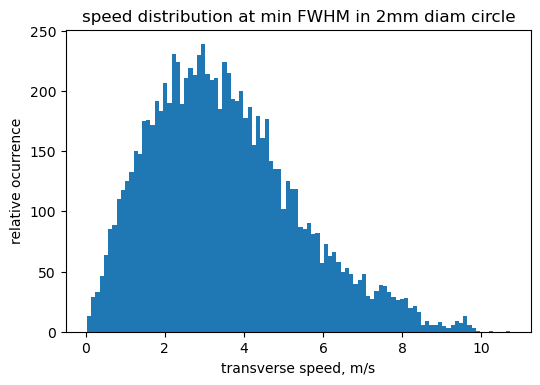

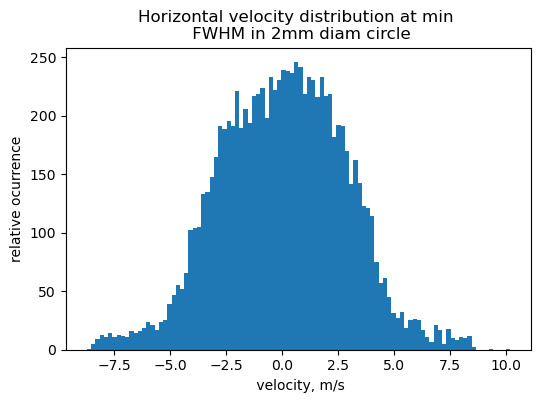

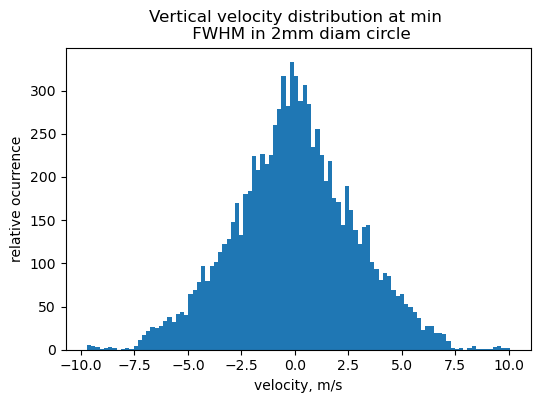

S90 is: 6.1 m/s


In [128]:
### velocity distribution in 1cm diam circle at min FWHM
r_ap_circle=1 #mm
fwhm_x_focus=1.894
y_vals,z_vals,p_vals=analyzer.interpolate(fwhm_x_focus, max_radius_mm=r_ap_circle,return_p=True)
px_vals,py_vals,pz_vals=p_vals.T
speed_trans=np.sqrt(py_vals**2+pz_vals**2)

circle_diam_str=str(round(2*r_ap_circle,2))

plt.figure(dpi=100)
plt.title("speed distribution at min FWHM in "+circle_diam_str+"mm diam circle")
plt.hist(speed_trans,bins=100)
plt.ylabel('relative ocurrence')
plt.xlabel("transverse speed, m/s")
plt.show()
plt.figure(dpi=100)
plt.title("Horizontal velocity distribution at min \n FWHM in "+ circle_diam_str+"mm diam circle")
plt.hist(py_vals,bins=100)
plt.ylabel('relative ocurrence')
plt.xlabel(" velocity, m/s")
plt.show()
plt.figure(dpi=100)
plt.title("Vertical velocity distribution at min \n FWHM in "+circle_diam_str+"mm diam circle")
plt.hist(pz_vals,bins=100)
plt.xlabel("velocity, m/s")
plt.ylabel('relative ocurrence')
plt.show()

s90=np.sort(speed_trans)[round(len(speed_trans)*.9)]
print("S90 is: "+str(round(s90,1))+' m/s')

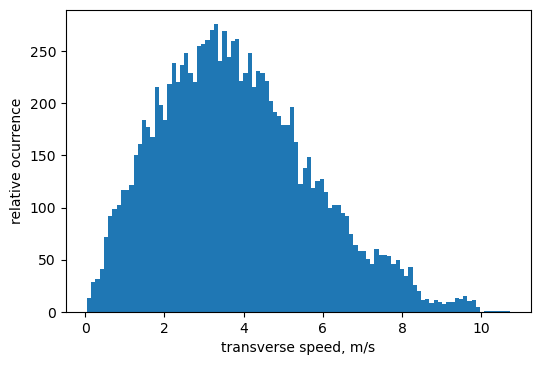

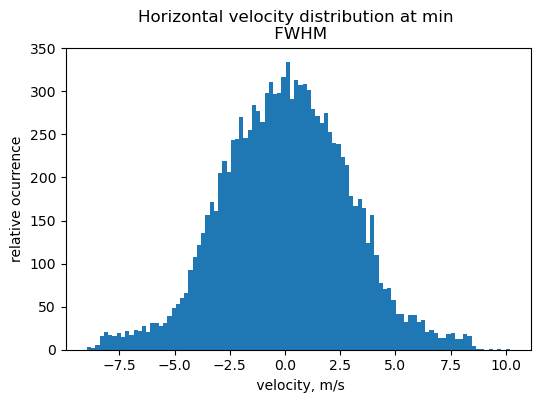

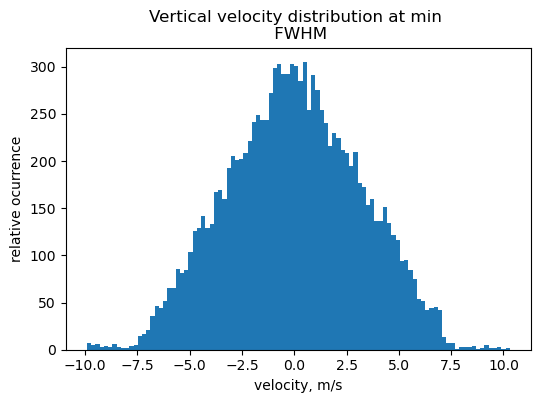

In [153]:
y_vals,z_vals,p_vals=analyzer.interpolate(fwhm_x_focus,return_p=True)
y_max=.5
z_max=2.5
valid_indices=(np.abs(y_vals)<y_max) & (np.abs(z_vals)<z_max)
p_vals=p_vals[valid_indices]

px_vals,py_vals,pz_vals=p_vals.T
speed_trans=np.sqrt(py_vals**2+pz_vals**2)



plt.figure(dpi=100)

plt.hist(speed_trans,bins=100)
plt.ylabel('relative ocurrence')
plt.xlabel("transverse speed, m/s")
plt.show()
plt.figure(dpi=100)
plt.title("Horizontal velocity distribution at min \n FWHM")
plt.hist(py_vals,bins=100)
plt.ylabel('relative ocurrence')
plt.xlabel(" velocity, m/s")
plt.show()
plt.figure(dpi=100)
plt.title("Vertical velocity distribution at min \n FWHM")
plt.hist(pz_vals,bins=100)
plt.xlabel("velocity, m/s")
plt.ylabel('relative ocurrence')
plt.show()



In [133]:
np.mean(p_vals[:,0]),np.std(p_vals[:,0])

(210.41022810046508, 25.884061075721295)

In [71]:
### survival at focus



percent of particles surviving to circle of diam 10 mm : 47


In [46]:
### focus s90

percent of particles surviving to circle of diam 10 mm : 47


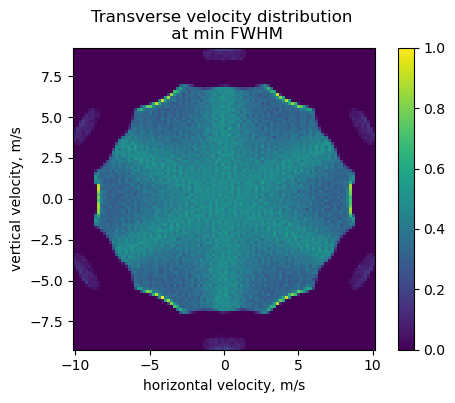

In [6]:
### 2D iamge of velocity distribution at focus

y_vals,z_vals=analyzer.interpolate(fwhm_x_focus, max_radius_mm=r_ap_circle)
full_ap_adjustment=(ap/.05)**2
frac_survival=full_ap_adjustment*len(y_vals)/num_particles
print('percent of particles surviving to circle of diam '+str(2*r_ap_circle)+ ' mm : '+str(round(1e2*frac_survival)))

image,binsy,binsz=np.histogram2d(py_vals,pz_vals,100)
image=image/np.max(image)
image=np.rot90(image)
binsy,binsz=binsz,binsy

plt.figure(dpi=100)
plt.title("Transverse velocity distribution \n at min FWHM")
plt.imshow(image,extent=[binsy.min(),binsy.max(),binsz.min(),binsz.max()],aspect=binsy.max()/binsz.max())

plt.xlabel("horizontal velocity, m/s")
plt.ylabel("vertical velocity, m/s")
plt.colorbar()

plt.show()

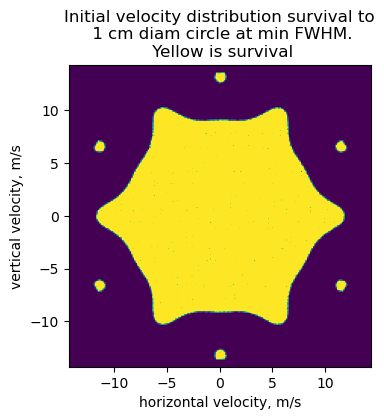

In [8]:
### distribution of survival into 1cm circle at x_fwhm from initial distirbution
fwhm_x_focus=1.894
_,_,p_vals,valid_indices=analyzer.interpolate(fwhm_x_focus, max_radius_mm=r_ap_circle,return_p=True,return_valid_indices=True)
py,pz=[],[]
weights=[0]*num_particles
for index in range(num_particles):
    p=swarm_traced.particles[index].pi
    py.append(p[1])
    pz.append(p[2])
for index in valid_indices:
    weights[index]=1
image,binsy,binsz=np.histogram2d(py,pz,200,weights=weights)
image=image/np.max(image)
image=np.rot90(image)
plt.figure(dpi=100)
plt.title("Initial velocity distribution survival to\n 1 cm diam circle at min FWHM.\n Yellow is survival")
plt.imshow(image,extent=[binsy.min(),binsy.max(),binsz.min(),binsz.max()],vmax=.5)
plt.xlabel("horizontal velocity, m/s")
plt.ylabel("vertical velocity, m/s")
# cbar.set_label('Survival')
plt.show()

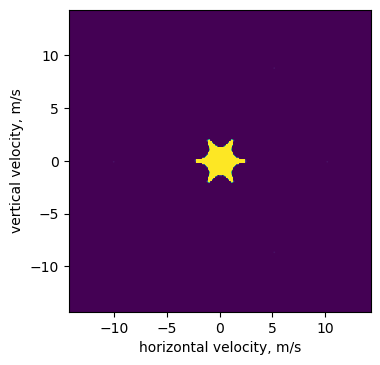

In [109]:
### survival into FWHM region from initial
%matplotlib inline
_,_,p_vals,valid_indices=analyzer.interpolate(fwhm_x_focus, max_radius_mm=.01,return_p=True,return_valid_indices=True)
py,pz=[],[]
weights=[0]*num_particles
for index in range(num_particles):
    p=swarm_traced.particles[index].pi
    py.append(p[1])
    pz.append(p[2])
for index in valid_indices:
    weights[index]=1
image,binsy,binsz=np.histogram2d(py,pz,200,weights=weights)
image=image/np.max(image)
image=np.rot90(image)
plt.figure(dpi=100)
# plt.title("Initial velocity distribution survival to\n 2 mm diam circle at min FWHM.\n Yellow is survival")
plt.imshow(image,extent=[binsy.min(),binsy.max(),binsz.min(),binsz.max()],vmax=.1)
plt.xlabel("horizontal velocity, m/s")
plt.ylabel("vertical velocity, m/s")
# cbar.set_label('Survival')
plt.show()

In [49]:
# # #trace and plot
# #
# #
# #
%matplotlib inline
swarm_traced_small=st.trace_swarm_through_lattice(goofy_swarm,5e-6,1.0,parallel=True,use_fast_mode=False,accelerated=True,steps_per_logging=4)
lattice.show_lattice(swarm=swarm_traced_small,trace_line_alpha=.2,true_aspect_ratio=False,plot_outer=True,save_title='trace',dpi=300,show_markers=False)

NameError: name 'goofy_swarm' is not defined